In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import requests
import mplcyberpunk

from bcb import sgs
from bcb import currency
from datetime import datetime

# Data inicial e Data final

Obs: Como será calculado a inflação acumulada de 12 meses, os primeiros doze meses não apareceção no período.

In [2]:
initial_date = '2000-01-01'
end_date = datetime.now()

### Obtendo os índices de inflação: IPCA e IGP-M

In [3]:
ipca_code = 433
igpm_code = 189

mensal_inflation = sgs.get({
    'ipca': ipca_code,
    'igp-m': igpm_code
}, start=initial_date, end=end_date)

### Obtendo o dólar

In [4]:
diary_dolar = currency.get('USD', start=initial_date, end=end_date)
mensal_dolar = diary_dolar.resample('M').last()

dolar_last_line = mensal_dolar.last(offset=('2D'))

if dolar_last_line.index.day[0] != 1:
    mensal_dolar = mensal_dolar.drop(dolar_last_line.index.values[0])

mensal_dolar.index = mensal_inflation.index
mensal_dolar = mensal_dolar.pct_change()

### Obtendo a SELIC

In [5]:
selic_code = 432

diary_selic = sgs.get({'selic': selic_code}, start=initial_date, end=end_date)
mensal_selic = diary_selic.resample('M').last()

selic_last_line = mensal_selic.last(offset=('2D'))

if selic_last_line.index.day[0] != 1:
    mensal_selic = mensal_selic.drop(selic_last_line.index.values[0])

mensal_selic.index = mensal_inflation.index

## Criando o dataframe com os valores absolutos em porcentagem

In [6]:
initial_row = 1
last_initial_row = len(mensal_inflation) - 12
new_index = mensal_inflation.iloc[13 : len(mensal_inflation)].index

In [10]:
df_absolute = pd.DataFrame()
df_absolute['IPCA'] = mensal_inflation['ipca']
df_absolute['IGP-M'] = mensal_inflation['igp-m']
df_absolute['DOLAR'] = mensal_dolar
df_absolute.fillna(value=0, inplace=True)
df_absolute

,IPCA,IGP-M,DOLAR
Date,,,
2000-01-01,0.62,1.24,0.000000
2000-02-01,0.13,0.35,-0.018808
2000-03-01,0.22,0.15,-0.011988
2000-04-01,0.42,0.23,0.033995
2000-05-01,0.01,0.31,0.011015
...,...,...,...
2022-05-01,0.47,0.52,-0.038666
2022-06-01,0.67,0.59,0.107657
2022-07-01,-0.68,0.21,-0.009469


### Convertendo o dataframe de números absolutos em acumulado de 12 meses

In [8]:
accumulated_df_list = []

for i in range(initial_row, last_initial_row):
    accumulated = df_absolute.iloc[i + 1 : i + 12].sum()
    accumulated_df_list.append(pd.DataFrame.from_records([accumulated]))

df = pd.concat(accumulated_df_list)
df.index = new_index
df['SELIC'] = mensal_selic.iloc[13 : ]
df['DOLAR'] = df['DOLAR'].apply(lambda x: round(x * 100, 2))

In [9]:
df

,IPCA,IGP-M,DOLAR,SELIC
Date,,,,
2001-02-01,5.65,8.58,11.08,15.25
2001-03-01,5.89,8.66,16.04,15.75
2001-04-01,5.85,8.99,18.33,16.25
2001-05-01,6.42,9.68,18.30,16.75
2001-06-01,6.60,9.69,27.78,18.25
...,...,...,...,...
2022-05-01,10.68,9.73,-5.25,12.75
2022-06-01,10.62,9.65,-4.72,13.25
2022-07-01,10.33,9.46,3.66,13.25


In [62]:
plt.rc('figure', figsize=(15, 5))
plt.style.use('cyberpunk')

# Gráfico da taxa SELIC

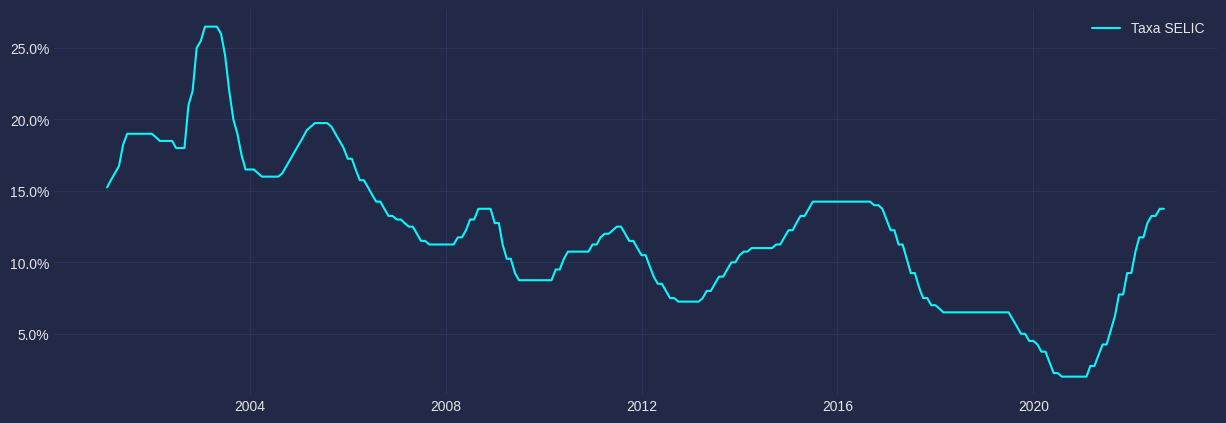

In [63]:
fig, ax = plt.subplots()

ax.plot(df.index, df['SELIC'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(['Taxa SELIC'])

# Gráfico do dólar

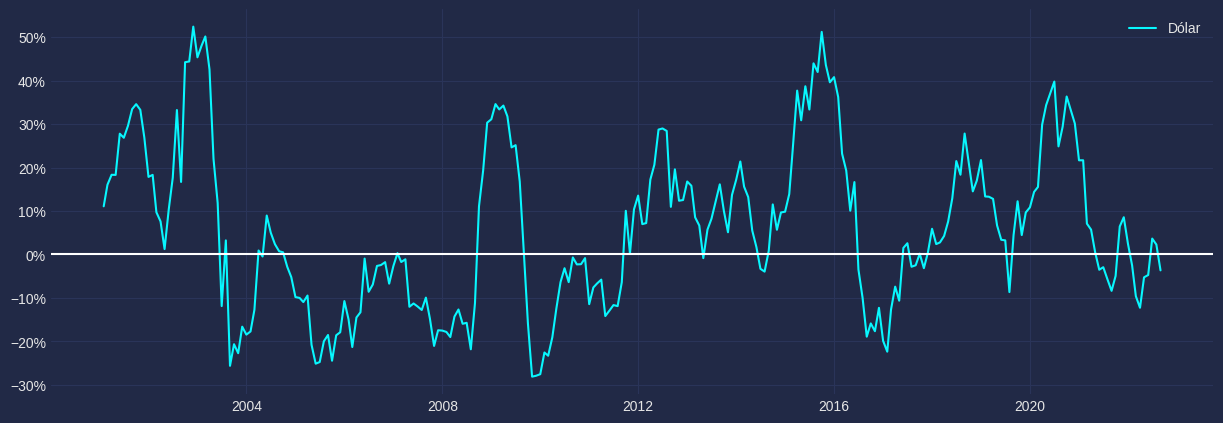

In [64]:
fig, ax = plt.subplots()
plt.plot(df.index, df['DOLAR'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.axhline(y=0, color='w')
plt.legend(['Dólar'])

# Gráfico da inflação

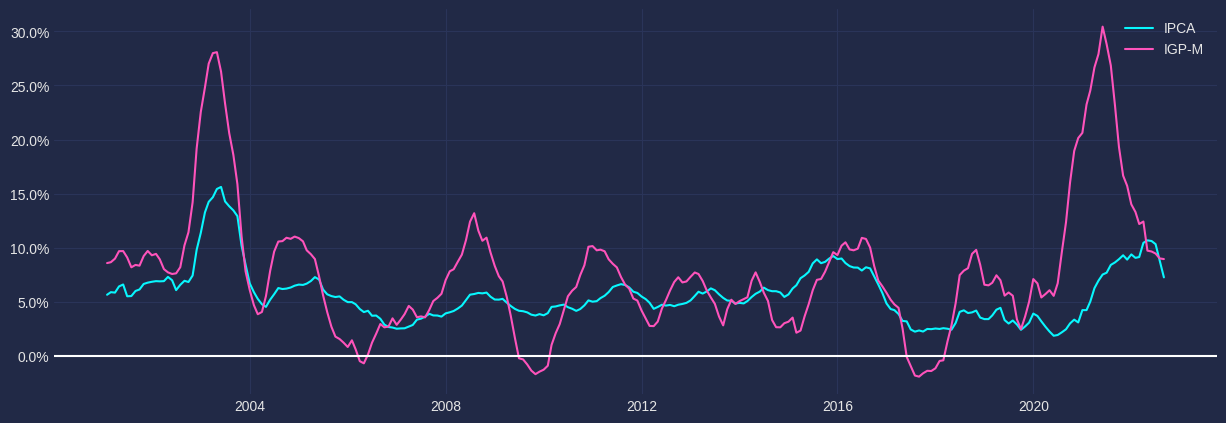

In [65]:
fig, ax = plt.subplots()

ax.plot(df.index, df['IPCA'])
ax.plot(df.index, df['IGP-M'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.axhline(y=0, color='w')
plt.legend(['IPCA', 'IGP-M'])

# Descartar

In [66]:
ipca_list = []
igpm_list = []
dolar_list = []

for i in range(initial_row, last_initial_row):
    accumulated = df_absolute.iloc[i + 1 : i + 12].sum()
    ipca_list.append(accumulated['IPCA'])
    igpm_list.append(accumulated['IGP-M'])
    dolar_list.append(accumulated['DOLAR'])

df['SELIC'] = mensal_selic.iloc[13 : ]
df['IPCA'] = ipca_list
df['IGP-M'] = igpm_list
df['DOLAR'] = dolar_list
df['DOLAR'] = df['DOLAR'].apply(lambda x: x * 100)
df.index = new_index